# Естимација на на должина на чекор со OpenPose




## Инсталација на OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob2
import shutil
import glob
import json
import math

In [ ]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
video_id = 'VID20230131152716'

Вчитување на горното видео од Drive и користење на OpenPose врз него

In [ ]:
!rm -rf ./openpose/output

!ffmpeg -y -loglevel info -i '/content/drive/MyDrive/Colab Notebooks/videos/{video_id}.mp4'  video.mp4

!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi 
# конвертирање на излезното видео во mp4 и зачувување на Drive
!ffmpeg -y -loglevel info -i openpose.avi '/content/drive/MyDrive/Colab Notebooks/openpose-videos/output_{video_id}.mp4'

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Визуелизација на резултатот

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video(f'/content/drive/MyDrive/Colab Notebooks/openpose-videos/output_{video_id}.mp4', width=960, height=720)

Output hidden; open in https://colab.research.google.com to view.

## Креирање на JSON фајл каде се наоѓаат вредностите добиени од OpenPose

In [ ]:
dir = "/content/openpose/output"
print ('file count: ' + str(len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])))

data = []
for name in sorted(glob.glob(dir + '/*_keypoints.json')):
    # print(name)
    try:
        f = open(name,)
        d = json.load(f)
        data.append([os.path.basename(name), d['people']])
    except ValueError:  # includes simplejson.decoder.JSONDecodeError
        print(f'Decoding JSON has failed: {name}')

with open(f'/content/drive/MyDrive/Colab Notebooks/combined-jsons/combined_{video_id}.json', 'w') as outfile:
    json.dump(data, outfile)

file count: 242


## Делење на видеото кое го добивме од OpenPose на посебни фрејмови

In [ ]:
!rm -rf '/content/drive/MyDrive/Colab Notebooks/tmp-frames'
!mkdir '/content/drive/MyDrive/Colab Notebooks/tmp-frames'
!ffmpeg -i '/content/drive/MyDrive/Colab Notebooks/openpose-videos/output_{video_id}.mp4' '/content/drive/MyDrive/Colab Notebooks/tmp-frames/%09d.png'

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

## Детекција на ArUco маркерите

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/tmp-frames/000000001.png') #Го земаме првиот фрејм и во него го детектираме маркерот
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

parameters = cv2.aruco.DetectorParameters_create()
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_5X5_50)

corners, _, _ = cv2.aruco.detectMarkers(image, aruco_dict, parameters=parameters)

print(corners)

euclidean_dst = np.linalg.norm(corners[0][0][0] - corners[0][0][1])
pixels_per_cm = euclidean_dst/16
factor = 1/pixels_per_cm

print(factor)

## Обработка на податоците од OpenPose

In [ ]:

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
distances = []
xl = []
yl = []
xr = []
yr = []
conf_l = []
conf_r = []
def extract_pose_keypoints(file_path):
    with open(file_path) as f:
        data = json.load(f)
  
    for item in data:
        for sub_item in item[1]:
            pose_keypoints = sub_item["pose_keypoints_2d"]
            distances.append(euclidean_distance(pose_keypoints[63], pose_keypoints[64], pose_keypoints[72], pose_keypoints[73]))
            xl.append(pose_keypoints[63])
            xr.append(pose_keypoints[72])
            yl.append(pose_keypoints[64])
            yr.append(pose_keypoints[73])
            conf_l.append(pose_keypoints[65])
            conf_r.append(pose_keypoints[74])
            if(pose_keypoints[63]==0 or pose_keypoints[64]==0 or pose_keypoints[72]==0 or pose_keypoints[73]==0):
              print("Има нулта вредност, потребен е филтер!")
    return xl, xr, yl, yr, distances, conf_l, conf_r

#file_path = "combined.json"
file_path = f'/content/drive/MyDrive/Colab Notebooks/combined-jsons/combined_{video_id}.json'
xl, xr, yl, yr, distances, conf_l, conf_r = extract_pose_keypoints(file_path)
print("distances:", distances)
print("xl:", xl)
print("xr:", xr)
print("yl:", yl)
print("yr:", yr)
print("conf_l:", conf_l)
print("conf_r:", conf_r)

distances: [97.55192164175959, 97.82516777394255, 94.63711779740552, 97.54738223038075, 94.9773666722762, 100.76145463420025, 95.37041831721196, 94.37573217729226, 106.21376717732971, 109.13981579606953, 103.32534198830412, 106.11966675880583, 109.53222324959903, 113.17851217435224, 112.45004335259284, 114.98003041398101, 112.20930892310135, 114.78398390890602, 114.65229718588284, 114.6841661302902, 111.86632605480521, 114.74883147553179, 114.78458915725577, 114.8135042318629, 114.80551772454147, 114.83720583939687, 117.74924849866342, 118.05663353238569, 118.324006123018, 118.21364703789492, 120.68557246000869, 124.12036675743431, 118.24407625331598, 106.57117126596664, 95.39623611547785, 77.88679047181232, 74.95128404503824, 74.43013530150266, 64.85073943294711, 70.6927958776565, 76.53030935518294, 81.94659361437785, 85.60786438756656, 86.96326558380841, 90.8944234208018, 94.74697588841553, 103.8050714849713, 108.14470173799548, 114.71492312685393, 119.25189227848759, 135.45809216506

In [ ]:
list_zeros = []
for i in range(len(xl)):
  a=1
  if(xl[i]==0 or yl[i]==0):
    if(xl[i+1]==0 or yl[i+1]==0):#ne bese prvicno planirano, no ova e ako 2 ili povekje sosedni se so vrednost 0
       xl[i]=(xl[i-1])
       yl[i]=(yl[i-1])
       a=0
       list_zeros.append(i)
    else:
      xl[i]=(xl[i-1]+xl[i+1])/2
      yl[i]=(yl[i-1]+yl[i+1])/2
      a=0
      list_zeros.append(i)
  if(yr[i]==0 or xr[i]==0):
    yr[i]=(yr[i-1]+yr[i+1])/2
    xr[i]=(xr[i-1]+xr[i+1])/2
    if(a==1):
      list_zeros.append(i)
print(list_zeros)      

In [ ]:
#ПРЕПОРАЧУВАЊЕ: Пред да се исцрта овој график, исцртај го графикот "Промена на дистанца" за да ја воочиш разликата и да се провери дали добро ги отстранува нулите
for i in (list_zeros):
  distances[i] = euclidean_distance(xl[i], yl[i], xr[i], yr[i])
  print(i)

In [ ]:
max_evklidovo = []
max_evklidovo_value = []
def first_x_under_50(x):
    for i, value in enumerate(x):
        if value < 50:
            if i > 35:#Zavisno od videoto, ovaa vrednost treba da se menuva
              return i#So ova planot e da gi trgneme laznite maksimumi koi se pojavuvaat so dolnata funkcija
    return None

for i in range(first_x_under_50(distances), len(xl)-10, 1):
  temp=1
  for j in range(1, 5, 1):
    if(distances[i]<distances[i+j] or distances[i]<distances[i-j]):
      temp=0
  if(temp==1):
    max_evklidovo.append(i)
    max_evklidovo_value.append(distances[i])

Confidence вредностите и координатите за петиците ги зачувуваме во JSON фајл

In [ ]:
conf_dict = {'l': conf_l, 'r': conf_r, 'xl': xl, 'xr': xr, 'yl': yl, 'yr': yr}

with open(f'/content/drive/MyDrive/Colab Notebooks/conf-jsons/conf_{video_id}.json', 'w') as outfile:
    json.dump(conf_dict, outfile)

In [ ]:
max_evklidovo = []
max_evklidovo_value = []
def first_x_under_50(x):#Da ja zeme prvata vrednost kade sto distancata pomegju nozete pagja pod 50, za da pocne ekstremite od tamu da gi meri
    for i, value in enumerate(x):
        if value < 50:
            return i#So ova planot e da gi trgneme laznite maksimumi koi se pojavuvaat so dolnata funkcija
    return None
for i in range(first_x_under_50(distances), len(xl)-20, 1):#-20 bidejki vo videata na krajot se pojavuvaat nepotrebni ekstremi
  temp=1
  for j in range(1, 5, 1):
    if(distances[i]<distances[i+j] or distances[i]<distances[i-j]):
      temp=0
  if(temp==1):
    max_evklidovo.append(i)
    max_evklidovo_value.append(distances[i])

Вредностите за растојанијата ги зачувуваме во JSON фајл

In [ ]:
evklidovo_dict = {'max_evklidovo': max_evklidovo, 'max_evklidovo_value': max_evklidovo_value}

with open(f'/content/drive/MyDrive/Colab Notebooks/evklidovo-jsons/evklidovo_{video_id}.json', 'w') as outfile:
    json.dump(evklidovo_dict, outfile)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(xl)), xl, color='red', label="Лева")
plt.plot(np.arange(len(xr)), xr, color='blue', label="Десна")

plt.title(r"Промена на позицијата по x оска")
plt.ylabel(r"")
plt.xlabel("Број на фрејм")
plt.legend(loc="upper left")

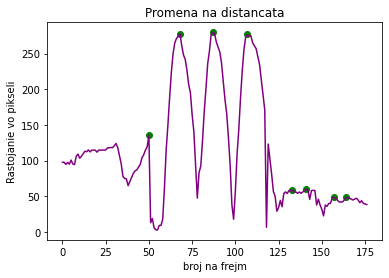

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(distances)), distances, color='purple')
plt.title(r"Промена на дистанца")
plt.ylabel(r"Растојание во пиксели")
plt.xlabel("Број на фрејм")
plt.scatter(max_evklidovo, max_evklidovo_value, color='green', label="Eкстреми")
plt.scatter(list_zeros, 0, color='yellow', label="Нулти вредности")
plt.legend(loc="upper left")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
plt.plot(np.arange(len(xl)),conf_l, color='firebrick', label="Лева")
plt.plot(np.arange(len(xr)), conf_r, color='navy', label="Десна")
plt.title(r"Промена на confidence")
plt.ylabel(r"")
plt.xlabel("Број на фрејм")
plt.legend(loc="lower left")

## Исцртување на линии и дистанци на сите фрејмови

In [ ]:
images = sorted(glob2.glob('/content/drive/MyDrive/Colab Notebooks/tmp-frames/*'))

for i in range(len(images)):
    image = cv2.imread(f'{images[i]}')

    first_point= np.int0([int(xl[i]),int(yl[i])])
    second_point= np.int0([int(xr[i]),int(yr[i])])

    text_point_x = int(min(first_point[0], second_point[0]) + abs(first_point[0] - second_point[0])/2) - 60
    text_point_y = int(min(first_point[1], second_point[1]) + abs(first_point[1] - second_point[1])/2) - 20


    image = cv2.line(image, first_point, second_point, (0,255,0), 5)
    image = cv2.putText(image, f'{round(int(distances[i])*factor, ndigits=5)}', (text_point_x,text_point_y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, thickness=3, fontScale=1.5, color=(0,0,255))
    cv2.imwrite(f'{images[i]}', image, )

## Спојување на фрејмовите во едно видео

In [ ]:
!ffmpeg -framerate 30 -i '/content/drive/MyDrive/Colab Notebooks/tmp-frames/%09d.png' '/content/drive/MyDrive/Colab Notebooks/final-videos/final_{video_id}.mp4'

## За работа со excel

In [ ]:
import numpy as np

filename = "/content/drive/MyDrive/ColabNotebooks/Dimitar_excel_dolzini/dolzina_cekori_D_excel_5.txt"
array = np.loadtxt(filename)
len(array)

In [ ]:
#БИТНО: На графикот "Промена на дистанца" биди сигурен дека внесените екстреми се вистинските 
razlika = []
for i in range(len(array)):
  razlika.append(abs(array[i]-max_evklidovo_value[i]*0.228))
  #razlika.append(abs(array[i]-max_evklidovo_value[i]*0.231))#0.231 e за видеа од Мартин, 0.228 е за Димитар
print(razlika)

In [ ]:
import os
from contextlib import redirect_stdout
file_path = os.path.join("/content/drive/MyDrive/ColabNotebooks/abs_razlika", f'Razlika_za_VID20230131155656.txt')
with open(file_path, 'w') as f: 
   for i in range(len(razlika)):
    with redirect_stdout(f):
          print(razlika[i])

Додаток, лоцирање на екстреми каде ногата која е во движење ја проаѓа статичната нога

In [ ]:
levcekor = []
desencekor = []
cekori = []
cekor_frejm = []
temp=1
for i in range(len(xl)):
  if(temp==1):
    if(xr[i]>xl[i]):
      input = (xl[i-1]+xl[i]+xl[i+1])/3
      levcekor.append(input)
      cekori.append(input)
      cekor_frejm.append(i)
      print("Ja zacuvuvam levata od frejm",i)
      for j in range (5):
        print("Leva noga se dvizi vo frejm",i-2+j,xl[i-2+j])
      for j in range (5):
        print("Desna noga se dvizi vo frejm",i-2+j,xr[i-2+j])
      temp=0
  if(temp==0):
    if(xr[i]<xl[i]):
      input = (xr[i-1]+xr[i]+xr[i+1])/3
      desencekor.append(input)
      cekori.append(input)
      cekor_frejm.append(i)
      print("Ja zacuvuvam desnata od frejm",i)
      for j in range (5):
        print("Leva noga se dvizi vo frejm",i-2+j,xl[i-2+j])
      for j in range (5):
        print("Desna noga se dvizi vo frejm",i-2+j,xr[i-2+j])
      temp=1
#print(levcekor)
#print(desencekor) 
#print(cekori)   
print(cekor_frejm) 

In [ ]:
dolzina_cekori = []
for i in range(len(cekori)):
  dolzina_cekori.append(cekori[i+1]-cekori[i])
  print(cekori[i+1]-cekori[i])

In [ ]:
for i in range(5):
  print(dolzina_cekori[i]*0.231,"cm") #Зависно која снимка се рабти(0.231, 0.228)